# Evaluating the new Infobox impact on data quality

## What are the new infoboxes ?

* the dynamics infobox are listed here :  https://fr.wikipedia.org/wiki/Cat%C3%A9gorie:Mod%C3%A8le_appelant_des_modules_en_langage_Lua

In [7]:
from collections import Counter
file_path="/user/cringwal/home/Desktop/DBpedia_tests/WikidataEval/"
models=[]
with open(file_path+'liste_infobox_wikidata.txt') as f:
    for line in f:
        name=line.replace("\n","").replace(" ","")
        models.append({"name":name})
print(len(models)," new infoboxes templates")

418  new infoboxes templates


* but not all of them are infobox templates ! So we ask to the wikipedia API the pages linked to theses modeles if we found a significative number of "Wikidata" occurences inside, we could image that they are dynamic infobox feeded with data coming from Wikidata

In [10]:
import json
with open(file_path+"model_wikidata.json") as json_file:
    model_wikidata = json.load(json_file)



206
212


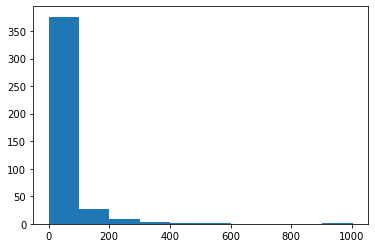

In [19]:
model_wikidata_sum=[model_wikidata[k]['wikidata']+model_wikidata[k]['Wikidata'] for k in model_wikidata.keys()]
import numpy as np
import matplotlib.pyplot as plt
plt.hist(model_wikidata_sum)
print( model_wikidata_sum.count(0))
count = sum(map(lambda x : x>0, model_wikidata_sum))
print(count)

In [42]:
# WE check mannually with this page having more than 1 occurences seems to be Infobox 
output = ["https://fr.wikipedia.org/wiki/"+list(model_wikidata.keys())[idx] for idx, element in enumerate(model_wikidata_sum) if element==2]
print(output)

['https://fr.wikipedia.org/wiki/Modèle:Infobox_Veine', 'https://fr.wikipedia.org/wiki/Modèle:Catégorise_personne', 'https://fr.wikipedia.org/wiki/Modèle:Infobox_Centre_de_congrès', 'https://fr.wikipedia.org/wiki/Modèle:Infobox_Fonction_mathématique', 'https://fr.wikipedia.org/wiki/Modèle:Infobox_Particule', 'https://fr.wikipedia.org/wiki/Modèle:Infobox_Obélisque', 'https://fr.wikipedia.org/wiki/Modèle:Infobox_Pyramide_égyptienne', 'https://fr.wikipedia.org/wiki/Modèle:Infobox_Timbre']


In [46]:
# So we put it in a list 
model_infobox = [list(model_wikidata.keys())[idx] for idx, element in enumerate(model_wikidata_sum) if element>1]
print(len(model_infobox)," template are dynamic Infoboxes")

177  template are dynamic Infoboxes


In [82]:
model_infobox

['Modèle:Infobox_Aire_protégée',
 'Modèle:Infobox_Animal',
 'Modèle:ArchivéPar',
 'Modèle:Infobox_Veine',
 'Modèle:Infobox_Artiste',
 'Modèle:AscendanceParWikidata',
 'Modèle:AscendanceParWikidata/4gen',
 'Modèle:AscendanceParWikidata/5gen',
 'Modèle:AscendanceParWikidata/6gen',
 'Modèle:Infobox_Astre',
 'Modèle:Infobox_Auteur_de_livre-jeu',
 'Modèle:Autorité',
 'Modèle:Infobox_Barrage',
 'Modèle:Barre_de_navigation',
 'Modèle:Bases',
 'Modèle:Bases_architecture',
 'Modèle:Bases_art',
 'Modèle:Bases_astronomie',
 'Modèle:Bases_audiovisuel',
 'Modèle:Bases_bande_dessinée',
 'Modèle:Bases_géographie',
 'Modèle:Bases_jeu',
 'Modèle:Bases_littérature',
 'Modèle:Bases_mode',
 'Modèle:Bases_multidisciplinaires',
 'Modèle:Bases_musique',
 'Modèle:Bases_organisation',
 'Modèle:Bases_recherche',
 'Modèle:Bases_religion',
 'Modèle:Bases_santé',
 'Modèle:Bases_spectacle',
 'Modèle:Bases_sport',
 'Modèle:Bases_tourisme',
 'Modèle:Bases_transport',
 'Modèle:Bases_vie_publique',
 'Modèle:Bases_vivan

## Focus on DBpedia 

### How many of them are mapped ?

In [50]:

import requests 
# We get the mapping file of DBpedia FR
url_mapping="https://raw.githubusercontent.com/dbpedia/extraction-framework/master/mappings/Mapping_fr.xml"
r = requests.get(url_mapping)
xml_string=r.text
mapped_infoboxes=[]
for name in model_infobox:
 if name.replace("Modèle:","") in xml_string:
    mapped_infoboxes.append(name)
print(len(mapped_infoboxes)," infoboxes are mapped in DBpedia FR")

2  infoboxes are mapped in DBpedia FR


### How many entities is it concerning ?

In [70]:
endpoint2022="http://prod-dbpedia.inria.fr/sparql"

query='''SELECT  COUNT(?s) as ?nb  
        FROM  <http://fr.dbpedia.org/graph/dbpedia_generic_article-templates> 
        WHERE {
        ?s <http://fr.dbpedia.org/property/wikiPageUsesTemplate> ?model
        }'''
r = requests.get(endpoint2022, params = {'format': 'json', 'query': query})
raw_data = r.json()
nb_total=raw_data['results']['bindings'][0]['nb']['value']


In [71]:

models=" ".join(["<http://fr.dbpedia.org/resource/"+infobox+">"for infobox in model_infobox])
query='''SELECT  COUNT(?s) as ?nb  
        FROM  <http://fr.dbpedia.org/graph/dbpedia_generic_article-templates> 
        WHERE {
        VALUES ?model {'''+models+'''}
        ?s <http://fr.dbpedia.org/property/wikiPageUsesTemplate> ?model
        }'''
r = requests.post(endpoint2022, data = {'format': 'json', 'query': query})
raw_data = r.json()
nb_dynamic=raw_data['results']['bindings'][0]['nb']['value']


In [72]:
print("-> ",nb_total," triplets describing template use of wikipedia pages")
print("-> ",nb_dynamic," of them are dynamic")
print("-> it represents a part of ",int(nb_dynamic)/int(nb_total)*100,"%")

->  26786001  triplets describing template use of wikipedia pages
->  1524364  of them are dynamic
-> it represents a part of  5.690898017960949 %


### Is it an increasing phenomena ?

So we don't have any view about that so we will mine the archive

In [83]:
with open(file_path+"wikidata_template_stats.json") as json_file:
    wikidata_template_stats = json.load(json_file)

In [90]:
table_by_year=[[],[]]
for y in wikidata_template_stats.keys():
    table_by_year[0].append(y)
    sum_=sum([wikidata_template_stats[y]["models_count"][m] for m in wikidata_template_stats[y]["models_count"].keys()])
    table_by_year[1].append((int(sum_)/int(wikidata_template_stats[y]["nb_lines"])*100))

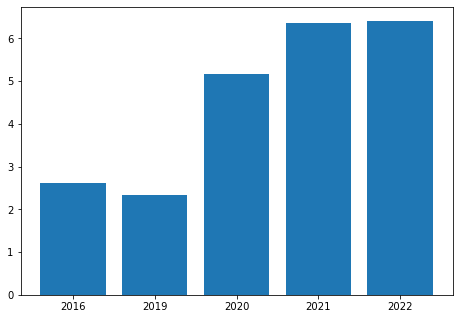

In [91]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(table_by_year[0],table_by_year[1])
plt.show()

### Which is the most used infoboxes ?

In [93]:

query='''SELECT ?model COUNT(?s) as ?nb  
        FROM  <http://fr.dbpedia.org/graph/dbpedia_generic_article-templates> 
        WHERE {
        VALUES ?model {'''+models+'''}
        ?s <http://fr.dbpedia.org/property/wikiPageUsesTemplate> ?model
        } GROUP BY ?model'''
r = requests.post(endpoint2022, data = {'format': 'json', 'query': query})
raw_data = r.json()



In [95]:
model_count={d["model"]["value"].replace("http://fr.dbpedia.org/resource/Modèle:",""):int(d["nb"]["value"]) for d in raw_data['results']['bindings']}
ordered=sorted(model_count.items(), key=lambda x: x[1], reverse=True)

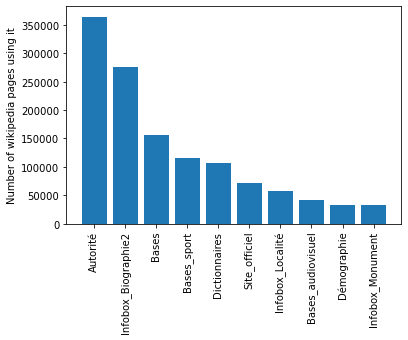

In [103]:
import numpy as np
import matplotlib.pyplot as plt
top_10=ordered[0:10]
# sort in-place from highest to lowest
top_10.sort(key=lambda x: x[1], reverse=True) 
# save the names and their respective scores separately
# reverse the tuples to go from most frequent to least frequent 
model = [d[0] for d in top_10]
nb = [d[1] for d in top_10]
x_pos = np.arange(len(model)) 

plt.bar(x_pos, nb,align='center')
plt.xticks(x_pos, model,rotation=90)
plt.ylabel('Number of wikipedia pages using it')
plt.show()


### Have it an impact on classes ?


In [112]:
query="SELECT  COUNT(?s) as ?nb  FROM  <http://fr.dbpedia.org/graph/dbpedia_generic_article-templates> WHERE { ?s <http://fr.dbpedia.org/property/wikiPageUsesTemplate> <http://fr.dbpedia.org/resource/Modèle:Infobox_Biographie2> }"
r = requests.get(endpoint2022, params = {'format': 'json', 'query': query})
raw_data = r.json()
nb_bio2=int(raw_data["results"]["bindings"][0]['nb']['value'])


In [111]:

query1='''SELECT ?id ?o FROM <http://fr.dbpedia.org/graph/dbpedia_mappings_instance-types>  WHERE {
?id rdf:type ?o.
{SELECT ?id  FROM <http://fr.dbpedia.org/graph/dbpedia_generic_article-templates> WHERE { ?id ?p <http://fr.dbpedia.org/resource/Modèle:Infobox_Biographie2>}}
}''' 
r = requests.get(endpoint2022, params = {'format': 'json', 'query': query1})
raw_data = r.json()

bio_class={}
for r in raw_data["results"]["bindings"]:
    if(r["id"]["value"] not in bio_class):
        bio_class[r["id"]["value"]]=[]
    if(r["o"]["value"]!='http://www.w3.org/2002/07/owl#Thing'):
        bio_class[r["id"]["value"]].append(r["o"]["value"])

count=len([bio_class[k] for k in bio_class.keys() if(len(bio_class[k])>0)])

print("====>>>> NB OF BIOGRAPHIE ENTITIES ",count)
print("====>>>> PART HAVING TODAY A TYPE ",count/nb_bio2)

====>>>> NB OF BIOGRAPHIE ENTITIES  96
====>>>> PART HAVING TODAY A TYPE  0.0003478828069793988


## Let's take focus on a sample

In [121]:
#We load the complete list of page that use the Infobox:Biographie2 template
with open(file_path+"list_bio2.json") as json_file:
    list_bio2 = json.load(json_file)

We needed a solution for weighting authors : we used the click stream of the year 2021 
https://meta.wikimedia.org/wiki/Research:Wikipedia_clickstream

In [139]:
import csv 
weighted_bio={}
for bio in list_bio2:
    b= bio.replace("http://fr.dbpedia.org/resource/","")
    weighted_bio[b]=0
month=["01","02","03","04","05","06","07","08","09","10","11","12"]
for m in month: 
    tsv_file = open(file_path+"clickstream/clickstream-frwiki-2021-"+m+".tsv")
    read_tsv = csv.reader(tsv_file, delimiter="\t")
    for row in read_tsv:
        if(row[1] in weighted_bio.keys()):
            weighted_bio[row[1]]=weighted_bio[row[1]]+int(row[3])
      
            

weighted_bio2=sorted(weighted_bio.items(), key=lambda x: x[1], reverse=True)

In [148]:
sample_size=int(len(list_bio2)*0.01)

In [149]:
sample=weighted_bio2[0:sample_size]

### What are the information given by Wikidata in term of properties ?

We first load the list of what could be mapped in the Biographie2 template from wikidata and from tDBpedia ontologies 

In [244]:
import csv
list_dbr=[]
list_wdt=[]
list_dbo=[]
dbr_dbo_dict={}
with open(file_path+'mapping_wikidata.csv', newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        row2=row[0].split(";")
        dbr=row2[0]
        while re.findall('\s[a-z]', dbr):
            m=re.search('\s[a-z]', dbr)
            dbr=dbr.replace(m.group(0),dbr[m.end()-1:m.end()].upper())
                           
        if(len(dbr)>0):
            list_dbr.append('http://fr.dbpedia.org/property/'+dbr.replace(" ",""))
        wdt=row2[1].replace(" ","")
        if(len(wdt)>0):
                list_wdt.append(wdt)
        if(len(row2)>2 and row2[2].replace(" ","")!=""):
            dbo=row2[2].replace(" ","").replace("https","http")
            if(len(dbo)>0):
                list_dbo.append(dbo.replace("foaf:","http://xmlns.com/foaf/0.1/"))
        if(len(dbr)>0 and len(row2)>2 and row2[2].replace(" ","")!=""):
            dbr_dbo_dict['http://fr.dbpedia.org/property/'+dbr.replace(" ","")]=dbo.replace("foaf:","http://xmlns.com/foaf/0.1/")
        


We request after that the wikidata_mappingbased-literals, containing wikidata properties mapped in the DBpedia ontology format and for comparison purpose we also get the raw infobox-properties for our sample

In [ ]:
#We load the complete list of page that use the Infobox:Biographie2 template
with open(file_path+"prop_by_bio2.json") as json_file:
    prop_by_bio2 = json.load(json_file)

[Text(1, 0, 'dbpedia'), Text(2, 0, 'wikidata')]

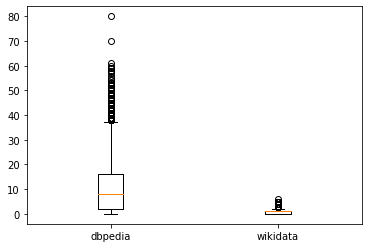

In [225]:
len_prop={"dbpedia":[],"wikidata":[]}
for k in prop_by_bio2.keys():
    len_prop["dbpedia"].append(len(prop_by_bio2[k]["dbpedia_prop"]))
    len_prop["wikidata"].append(len(prop_by_bio2[k]["wikidata_prop"]))
    
fig, ax = plt.subplots()
ax.boxplot(len_prop.values())
ax.set_xticklabels(len_prop.keys())

That is not surprising to get more information from the raw infobox properties, but we also note the poor quality of what is returned from wikidata

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe87976bb20>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe87976be50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe87976b340>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe879740b50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe879740c40>],
 'means': []}

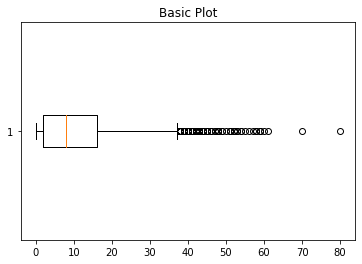

In [229]:
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(len_prop["dbpedia"],vert=False)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe8714d50a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe8714d5760>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe8714c8d00>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe8714d5e20>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe8714e21c0>],
 'means': []}

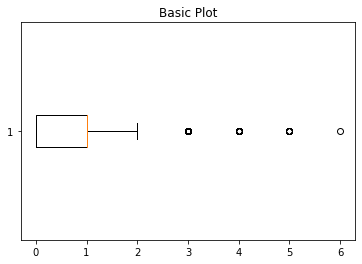

In [230]:
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(len_prop["wikidata"],vert=False)

Ok let's focus on what could be mapped and getted from the Biographie2 infobox

In [241]:
dbpedia_inBio2={}
for k in prop_by_bio2.keys():
    dbpedia_inBio2[k]=[]
    for prop in prop_by_bio2[k]["dbpedia_prop"]:
        if(prop in list_dbr):
            dbpedia_inBio2[k].append(prop)

[Text(1, 0, 'dbpedia2'), Text(2, 0, 'wikidata')]

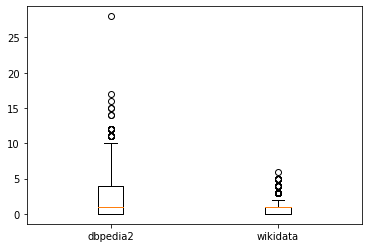

In [238]:
len_prop={"dbpedia2":[],"wikidata":[]}
for k in prop_by_bio2.keys():
    len_prop["dbpedia2"].append(len(dbpedia_inBio2[k]))
    len_prop["wikidata"].append(len(prop_by_bio2[k]["wikidata_prop"]))
    
fig, ax = plt.subplots()
ax.boxplot(len_prop.values())
ax.set_xticklabels(len_prop.keys())

Ok DBpedia prop could be mapped but which are the new properties that don't give wikidata ?

In [252]:
part_of_new=[]
prop_bio_dbpedia_bio2={}
for k in prop_by_bio2.keys():
    prop_bio_dbpedia_bio2[k]={"new":[],"in_wiki":[]}
    for prop in prop_by_bio2[k]["dbpedia_prop"]:
        if(prop in dbr_dbo_dict.keys()):
            if(dbr_dbo_dict[prop] in prop_by_bio2[k]["wikidata_prop"]):
                prop_bio_dbpedia_bio2[k]["in_wiki"].append(prop)
            else:
                prop_bio_dbpedia_bio2[k]["new"].append(prop)
    sum_=len(prop_bio_dbpedia_bio2[k]["new"])+len(prop_bio_dbpedia_bio2[k]["in_wiki"])
    if(sum_!=0):
        part_of_new.append(len(prop_bio_dbpedia_bio2[k]["new"])/sum_*100)
            

(array([7.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.200e+01,
        4.400e+01, 6.900e+01, 2.110e+02, 1.019e+03]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

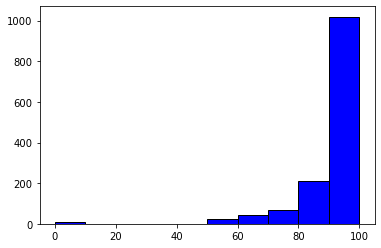

In [256]:
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib histogram
plt.hist(part_of_new, color = 'blue', edgecolor = 'black')